In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# 设置绘图风格
sns.set(style="whitegrid")
plt.rcParams['font.family'] = 'sans-serif' # 避免中文乱码，绘图主要用英文

# --- 1. 加载数据 ---
# 读取原始数据（包含选手特征：年龄、行业、舞伴等）
# 注意：假设原始数据可能是宽表(Wide)或长表(Long)。这里假设是比赛官方提供的格式
df_raw = pd.read_csv('2026_MCM_Problem_C_Data.csv', encoding='ISO-8859-1')

# 读取任务一生成的观众投票数据
# 假设该文件包含列：['season', 'week', 'celebrity_name', 'estimated_votes']
df_votes = pd.read_csv('task1_reconstructed_votes.csv')

print("Raw Data Shape:", df_raw.shape)
print("Votes Data Shape:", df_votes.shape)
print("\nRaw Columns:", df_raw.columns.tolist()[:5])
print("Votes Columns:", df_votes.columns.tolist())

Raw Data Shape: (421, 53)
Votes Data Shape: (2249, 7)

Raw Columns: ['ï»¿celebrity_name', 'ballroom_partner', 'celebrity_industry', 'celebrity_homestate', 'celebrity_homecountry/region']
Votes Columns: ['Season', 'Week', 'Contestant', 'Judge_Score_Raw', 'Reconstructed_Vote_Share', 'Result_Status', 'Is_Eliminated']


In [9]:
# --- 2. 数据清洗与特征提取 (修正版) ---

# 2.1 彻底清洗列名
def clean_column_names(df):
    # 去除 BOM 字符, 转换为小写, 去除前后空格, 将中间空格替换为下划线
    df.columns = [c.encode('ascii', 'ignore').decode('ascii').strip().lower().replace(' ', '_') for c in df.columns]
    return df

df_raw = clean_column_names(df_raw)
df_votes = clean_column_names(df_votes)

# 打印清洗后的列名，方便你核对
print("Cleaned Raw Columns:", df_raw.columns.tolist())
print("Cleaned Vote Columns:", df_votes.columns.tolist())

# 2.2 自动匹配选手列名
# 有些 CSV 里叫 'celebrity_name'，有些可能只叫 'celebrity' 或 'contestant'
def find_col(possible_names, df_cols):
    for name in possible_names:
        if name in df_cols: return name
    return None

# 这里的 'contestant' 是因为你的 task1 文件里使用了这个名称
raw_name_col = find_col(['celebrity_name', 'celebrity', 'contestant'], df_raw.columns)
vote_name_col = find_col(['contestant', 'celebrity_name', 'celebrity'], df_votes.columns)

if not raw_name_col or not vote_name_col:
    raise ValueError(f"Could not find celebrity name column. Raw: {raw_name_col}, Vote: {vote_name_col}")

# 统一名称以便合并
df_votes = df_votes.rename(columns={vote_name_col: 'celebrity_common'})
df_raw = df_raw.rename(columns={raw_name_col: 'celebrity_common'})

# 2.3 提取特征
# 根据你上传的 raw 数据，确认需要的列
cols_to_keep = ['season', 'celebrity_common', 'ballroom_partner', 
                'celebrity_industry', 'celebrity_age_during_season']

# 只选择存在的列
available_cols = [c for c in cols_to_keep if c in df_raw.columns]
df_features = df_raw[available_cols].drop_duplicates()

# 2.4 清洗“行业” (Industry)
def clean_industry(ind):
    if pd.isna(ind): return 'Other'
    ind = str(ind).lower()
    if any(x in ind for x in ['athlete', 'nfl', 'nba', 'olympic', 'swimmer', 'skater', 'player']):
        return 'Athlete'
    elif any(x in ind for x in ['actor', 'actress', 'movie', 'star']):
        return 'Actor'
    elif any(x in ind for x in ['singer', 'music', 'rapper', 'band']):
        return 'Musician'
    elif any(x in ind for x in ['reality', 'housewife', 'bachelor', 'tv_personality']):
        return 'Reality'
    else:
        return 'Other'

df_features['industry_group'] = df_features['celebrity_industry'].apply(clean_industry)

# 2.5 合并数据
# 注意：两个表的 season 类型要一致（都是 int）
df_votes['season'] = df_votes['season'].astype(int)
df_features['season'] = df_features['season'].astype(int)

df_analysis = pd.merge(df_votes, df_features, on=['season', 'celebrity_common'], how='left')

# 2.6 计算关键指标
# 计算每周得票份额（如果 task1 还没算的话）
if 'reconstructed_vote_share' in df_analysis.columns:
    df_analysis['fan_vote_share'] = df_analysis['reconstructed_vote_share']
else:
    # 如果只有绝对票数，则计算份额
    df_analysis['weekly_total'] = df_analysis.groupby(['season', 'week'])['estimated_votes'].transform('sum')
    df_analysis['fan_vote_share'] = df_analysis['estimated_votes'] / df_analysis['weekly_total']

# 标准化评委分 (使用 task1 里的 judge_score_raw)
df_analysis['judge_zscore'] = df_analysis.groupby('season')['judge_score_raw'].transform(lambda x: (x - x.mean()) / (x.std() + 1e-6))
df_analysis['fan_zscore'] = df_analysis.groupby('season')['fan_vote_share'].transform(lambda x: (x - x.mean()) / (x.std() + 1e-6))

print(f"Merge successful! Final shape: {df_analysis.shape}")
df_analysis.head()

Cleaned Raw Columns: ['celebrity_name', 'ballroom_partner', 'celebrity_industry', 'celebrity_homestate', 'celebrity_homecountry/region', 'celebrity_age_during_season', 'season', 'results', 'placement', 'week1_judge1_score', 'week1_judge2_score', 'week1_judge3_score', 'week1_judge4_score', 'week2_judge1_score', 'week2_judge2_score', 'week2_judge3_score', 'week2_judge4_score', 'week3_judge1_score', 'week3_judge2_score', 'week3_judge3_score', 'week3_judge4_score', 'week4_judge1_score', 'week4_judge2_score', 'week4_judge3_score', 'week4_judge4_score', 'week5_judge1_score', 'week5_judge2_score', 'week5_judge3_score', 'week5_judge4_score', 'week6_judge1_score', 'week6_judge2_score', 'week6_judge3_score', 'week6_judge4_score', 'week7_judge1_score', 'week7_judge2_score', 'week7_judge3_score', 'week7_judge4_score', 'week8_judge1_score', 'week8_judge2_score', 'week8_judge3_score', 'week8_judge4_score', 'week9_judge1_score', 'week9_judge2_score', 'week9_judge3_score', 'week9_judge4_score', 'week1

,season,week,celebrity_common,judge_score_raw,reconstructed_vote_share,result_status,is_eliminated,ballroom_partner,celebrity_industry,celebrity_age_during_season,industry_group,fan_vote_share,judge_zscore,fan_zscore
0,1,2,John O'Hurley,26.0,0.194210,2nd Place,False,Charlotte Jorgensen,Actor/Actress,50.0,Actor,0.194210,1.136285,-0.045864
1,1,2,Kelly Monaco,17.0,0.367751,1st Place,False,Alec Mazo,Actor/Actress,29.0,Actor,0.367751,-1.024257,1.328883
2,1,2,Evander Holyfield,14.0,0.138115,Eliminated Week 3,False,Edyta Sliwinska,Athlete,42.0,Athlete,0.138115,-1.744438,-0.490236
3,1,2,Rachel Hunter,24.0,0.115816,Eliminated Week 4,False,Jonathan Roberts,Model,35.0,Other,0.115816,0.656165,-0.666888
4,1,2,Joey McIntyre,21.0,0.141251,3rd Place,False,Ashly DelGrosso,Singer/Rapper,32.0,Musician,0.141251,-0.064016,-0.465398


In [10]:
# --- 3. 量化职业舞伴影响力 (Pro Dancer Effect) ---

# 计算每个舞伴的平均评委得分 (Judge Rating) 和 平均观众份额 (Fan Rating)
partner_stats = df_analysis.groupby('ballroom_partner').agg({
    'judge_zscore': 'mean',
    'fan_zscore': 'mean',
    'season': 'count' # 参赛次数
}).reset_index()

# 过滤掉只参加过1-2次的舞伴，避免噪音
partner_stats = partner_stats[partner_stats['season'] > 10] # 这里假设样本是周次，调整阈值

partner_stats.rename(columns={
    'judge_zscore': 'partner_hist_judge_perf', 
    'fan_zscore': 'partner_hist_fan_perf'
}, inplace=True)

# 将舞伴的历史能力值合并回主表
df_model = pd.merge(df_analysis, partner_stats[['ballroom_partner', 'partner_hist_judge_perf', 'partner_hist_fan_perf']], 
                    on='ballroom_partner', how='left')

# 填充缺失值（新舞伴用平均值填充）
df_model['partner_hist_judge_perf'].fillna(0, inplace=True)
df_model['partner_hist_fan_perf'].fillna(0, inplace=True)

/var/folders/f6/kqhwt20s1z3bjvgldy_q44vr0000gn/T/ipykernel_30822/2456554926.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_model['partner_hist_judge_perf'].fillna(0, inplace=True)
/var/folders/f6/kqhwt20s1z3bjvgldy_q44vr0000gn/T/ipykernel_30822/2456554926.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

In [11]:
# --- 4. 建立回归模型 (OLS) ---

# 1. 确保所有特征都是数值型
# 将 industry 转换为 0/1 (通过 dtype=int 强制转换)
dummy_industry = pd.get_dummies(df_model['industry_group'], prefix='ind', drop_first=True, dtype=int)

# 2. 定义自变量列表
# 基础特征 + 舞伴特征 + 行业特征
feature_cols = ['celebrity_age_during_season', 'partner_hist_judge_perf', 'partner_hist_fan_perf']
# 获取 dummy 所有的列名
industry_cols = dummy_industry.columns.tolist()
all_features = feature_cols + industry_cols

# 3. 准备建模数据集
# 合并 dummy 到主表
df_reg_prep = pd.concat([df_model, dummy_industry], axis=1)

# 定义目标变量
targets = ['judge_zscore', 'fan_zscore']

# 4. 关键步骤：清理数据
# 确保年龄是数值，非数值转为 NaN
df_reg_prep['celebrity_age_during_season'] = pd.to_numeric(df_reg_prep['celebrity_age_during_season'], errors='coerce')

# 只保留没有缺失值的行 (目标变量 + 自变量)
df_reg = df_reg_prep.dropna(subset=targets + all_features)

# 5. 提取 X 和 Y
X = df_reg[all_features].copy()
# 再次强制转换 X 的所有列为 float，彻底杜绝 "object" 类型问题
X = X.astype(float) 

# 添加常数项 (截距)
X = sm.add_constant(X)

# --- 运行模型 ---

# 模型 A: 预测评委偏好
model_judge = sm.OLS(df_reg['judge_zscore'], X).fit()

# 模型 B: 预测观众偏好
model_fan = sm.OLS(df_reg['fan_zscore'], X).fit()

# 6. 提取结果对比
res_compare = pd.DataFrame({
    'Feature': X.columns,
    'Judge_Coeff': model_judge.params,
    'Judge_Pval': model_judge.pvalues,
    'Fan_Coeff': model_fan.params,
    'Fan_Pval': model_fan.pvalues
}).reset_index(drop=True)

# 过滤掉截距项 (const)
res_compare = res_compare[res_compare['Feature'] != 'const']

# 格式化输出：只保留显著或重要的特征看一眼
print("--- Regression Coefficients (Impact Analysis) ---")
print(res_compare.round(4))

# 检查是否存在全为0或NaN的情况
if res_compare.empty:
    print("Warning: res_compare is empty. Check if data was dropped during dropna().")

--- Regression Coefficients (Impact Analysis) ---
                       Feature  Judge_Coeff  Judge_Pval  Fan_Coeff  Fan_Pval
1  celebrity_age_during_season      -0.0247      0.0000    -0.0260    0.0000
2      partner_hist_judge_perf       0.7590      0.0000    -0.2103    0.0221
3        partner_hist_fan_perf      -0.0912      0.2122     0.8686    0.0000
4                  ind_Athlete      -0.1530      0.0046     0.1055    0.0402
5                 ind_Musician      -0.0172      0.7728    -0.0409    0.4712
6                    ind_Other      -0.2747      0.0000    -0.0297    0.5169


<Figure size 1200x600 with 0 Axes>

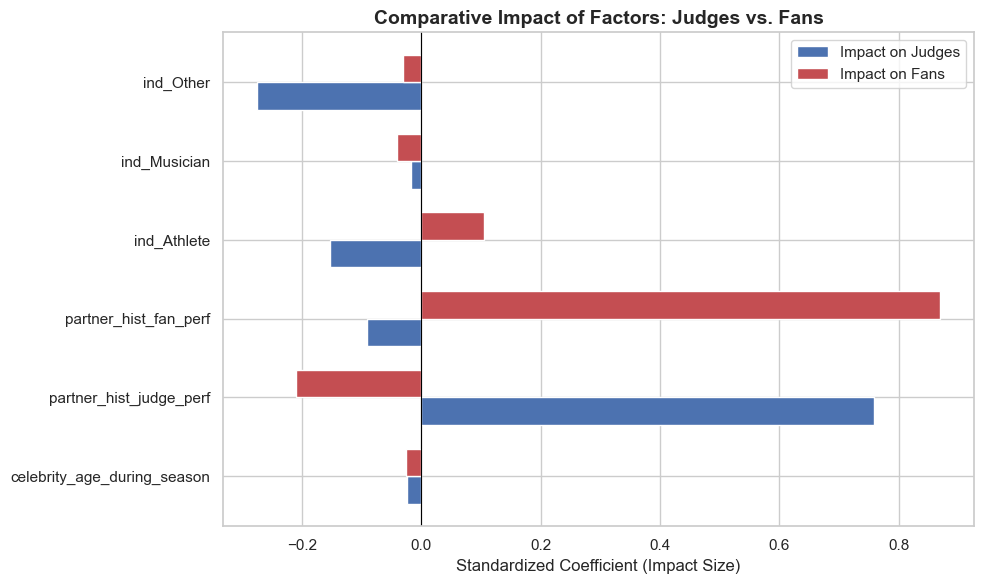

/var/folders/f6/kqhwt20s1z3bjvgldy_q44vr0000gn/T/ipykernel_30822/3111884744.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='industry_group', y='judge_zscore', data=df_model, palette='Blues')
/var/folders/f6/kqhwt20s1z3bjvgldy_q44vr0000gn/T/ipykernel_30822/3111884744.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='industry_group', y='fan_zscore', data=df_model, palette='Reds')


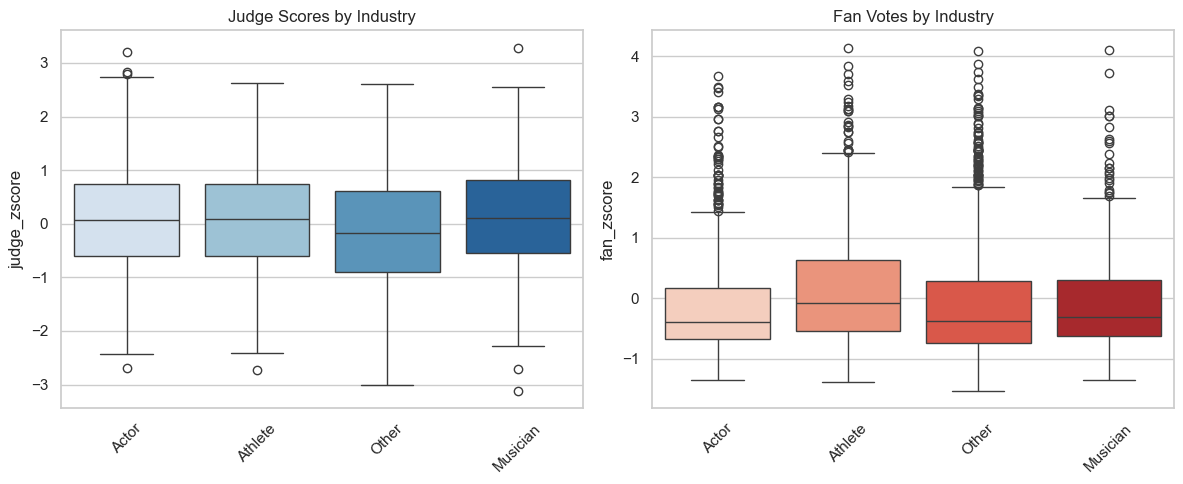

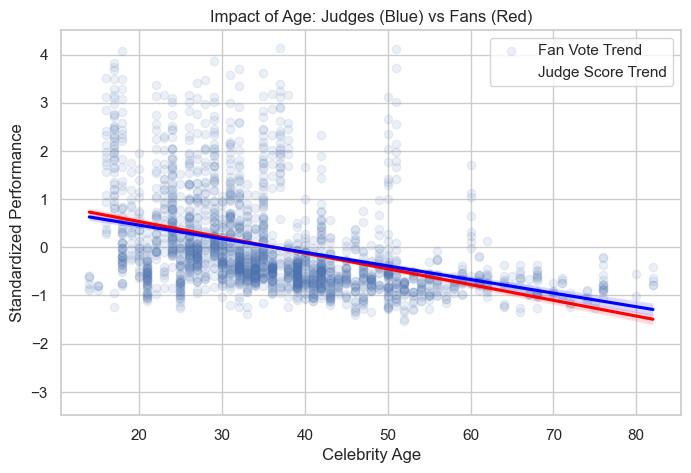

In [12]:
# --- 5. 结果可视化 ---

# 图 1: 蝴蝶图 (Butterfly Chart) - 对比评委与观众的偏好差异
plt.figure(figsize=(12, 6))

# 数据准备
features = res_compare['Feature']
judge_vals = res_compare['Judge_Coeff']
fan_vals = res_compare['Fan_Coeff']

y = np.arange(len(features))
height = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.barh(y - height/2, judge_vals, height, label='Impact on Judges', color='#4c72b0')
rects2 = ax.barh(y + height/2, fan_vals, height, label='Impact on Fans', color='#c44e52')

ax.set_yticks(y)
ax.set_yticklabels(features)
ax.set_xlabel('Standardized Coefficient (Impact Size)')
ax.set_title('Comparative Impact of Factors: Judges vs. Fans', fontsize=14, fontweight='bold')
ax.legend()
ax.axvline(0, color='black', linewidth=0.8)

plt.tight_layout()
plt.show()

# 图 2: 行业表现箱线图
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='industry_group', y='judge_zscore', data=df_model, palette='Blues')
plt.title('Judge Scores by Industry')
plt.xticks(rotation=45)
plt.xlabel('')

plt.subplot(1, 2, 2)
sns.boxplot(x='industry_group', y='fan_zscore', data=df_model, palette='Reds')
plt.title('Fan Votes by Industry')
plt.xticks(rotation=45)
plt.xlabel('')

plt.tight_layout()
plt.show()

# 图 3: 年龄影响散点图
plt.figure(figsize=(8, 5))
sns.regplot(x='celebrity_age_during_season', y='fan_zscore', data=df_model, 
            scatter_kws={'alpha':0.1}, line_kws={'color':'red'}, label='Fan Vote Trend')
sns.regplot(x='celebrity_age_during_season', y='judge_zscore', data=df_model, 
            scatter_kws={'alpha':0}, line_kws={'color':'blue'}, label='Judge Score Trend')
plt.legend()
plt.title('Impact of Age: Judges (Blue) vs Fans (Red)')
plt.xlabel('Celebrity Age')
plt.ylabel('Standardized Performance')
plt.show()

In [13]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import shap
import matplotlib.pyplot as plt

# 1. 准备特征矩阵 X 和目标变量 y
# 我们预测的是 'fan_zscore' (观众偏好)
# 也可以换成 'judge_zscore' 进行对比分析
X_shap = df_reg[all_features].copy()
y_shap = df_reg['fan_zscore']

# 2. 训练随机森林模型
# n_estimators: 树的数量；max_depth: 深度，避免过拟合
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_shap, y_shap)

print("随机森林模型训练完成。")
print(f"模型 R^2 得分: {rf_model.score(X_shap, y_shap):.4f}")

/Users/a1-6/anaconda3/envs/rllm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


随机森林模型训练完成。
模型 R^2 得分: 0.8228


In [14]:
# 3. 初始化 SHAP 解释器
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_shap)

# 注意：在某些 shap 版本中，对于回归问题，shap_values 直接就是数组
# 如果是多分类，它会是列表。这里我们处理回归。
print("SHAP 值计算完成。")

SHAP 值计算完成。


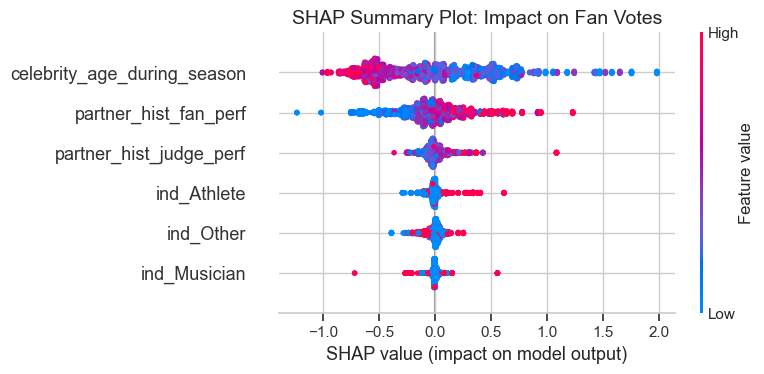

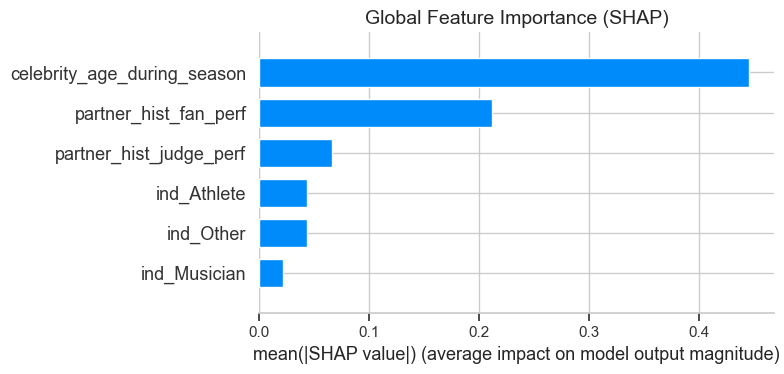

<Figure size 800x500 with 0 Axes>

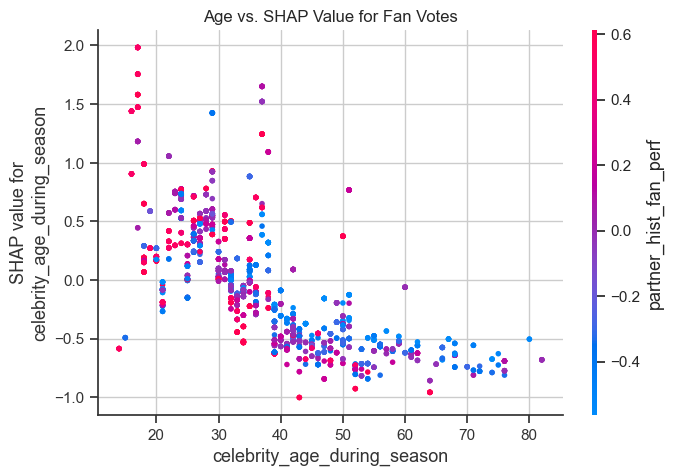

In [15]:
# --- 4. 可视化 ---

# 图 A: 特征重要性摘要图 (Summary Plot - Beeswarm)
# 这种图能显示特征对预测的正向或负向影响
plt.figure(figsize=(10, 6))
plt.title("SHAP Summary Plot: Impact on Fan Votes", fontsize=14)
shap.summary_plot(shap_values, X_shap, show=False)
plt.tight_layout()
plt.show()

# 图 B: 特征重要性条形图 (Global Importance)
plt.figure(figsize=(10, 6))
plt.title("Global Feature Importance (SHAP)", fontsize=14)
shap.summary_plot(shap_values, X_shap, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

# 图 C: 依赖图 (Dependence Plot) - 以年龄为例
# 展示年龄的变化如何具体影响 SHAP 值
plt.figure(figsize=(8, 5))
shap.dependence_plot("celebrity_age_during_season", shap_values, X_shap, show=False)
plt.title("Age vs. SHAP Value for Fan Votes", fontsize=12)
plt.show()

/var/folders/f6/kqhwt20s1z3bjvgldy_q44vr0000gn/T/ipykernel_30822/869662263.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(x_range, model_base.params[0] + model_base.params[1] * x_range, color='red', linestyle='--')
/var/folders/f6/kqhwt20s1z3bjvgldy_q44vr0000gn/T/ipykernel_30822/869662263.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_res, x='ind_group', y='controversy_index', palette='Set2')


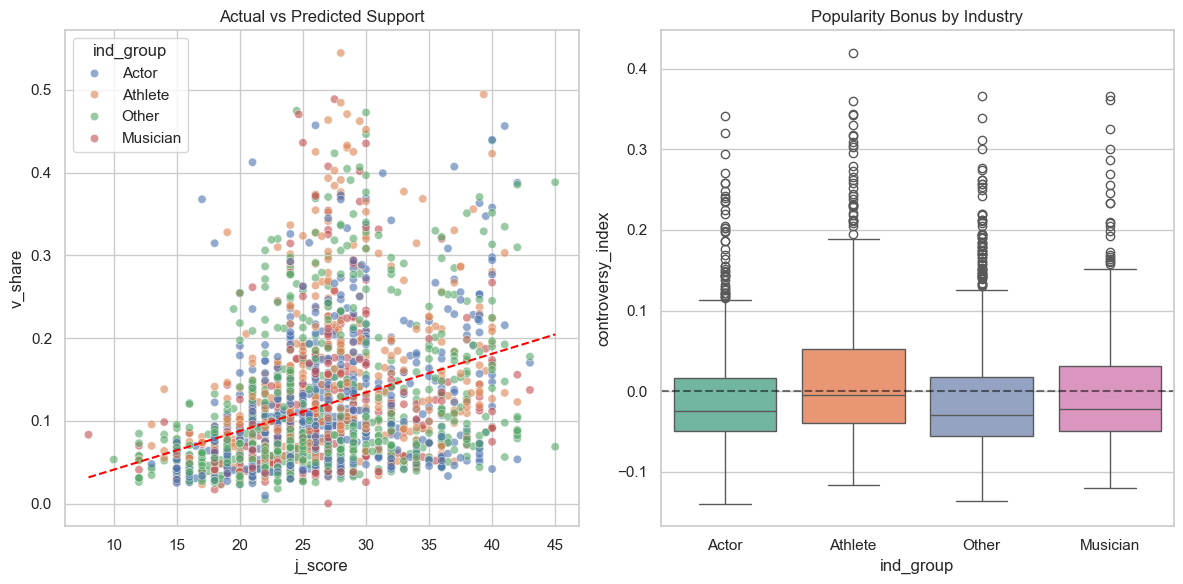

最具观众缘（残差最高）的前5名选手：
         celeb_key  j_score   v_share  controversy_index
447  Shawn Johnson  28.0000  0.544636           0.419612
373   Brooke Burke  24.5000  0.474779           0.366097
63     Drew Lachey  27.5000  0.488768           0.366077
536   Donny Osmond  24.6666  0.470340           0.360880
442  Shawn Johnson  28.0000  0.484497           0.359472


In [16]:
#争议性分析:我们已知评委分代表了选手的“硬实力”。用评委分去预测观众投票。残差 (Residual) = 实际投票 - 预测投票。如果残差为正且很大，说明这个选手拥有超越其舞蹈水平的“观众缘”或“争议性”。
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. 数据加载 ---
df_raw = pd.read_csv('2026_MCM_Problem_C_Data.csv', encoding='ISO-8859-1')
df_votes = pd.read_csv('task1_reconstructed_votes.csv')

# 自动清洗所有列名（去除空格、转小写）
df_raw.columns = [c.strip().lower() for c in df_raw.columns]
df_votes.columns = [c.strip().lower() for c in df_votes.columns]

# --- 2. 智能探测列名 ---
def get_col_name(df, patterns):
    for p in patterns:
        for col in df.columns:
            if p in col:
                return col
    return None

# 寻找选手名列
raw_name_col = get_col_name(df_raw, ['celebrity_name', 'contestant', 'celebrity'])
vote_name_col = get_col_name(df_votes, ['contestant', 'celebrity_name', 'celebrity'])

# 寻找评委分列
raw_score_col = get_col_name(df_votes, ['judge_score_raw', 'judge_score', 'score'])
# 寻找投票份额列
vote_share_col = get_col_name(df_votes, ['reconstructed_vote_share', 'vote_share', 'share'])

if not raw_name_col or not vote_name_col:
    print(f"Error: 找不到选手名列。Raw列名: {df_raw.columns.tolist()}")
else:
    # 统一命名
    df_raw = df_raw.rename(columns={raw_name_col: 'celeb_key', 'celebrity_industry': 'industry'})
    df_votes = df_votes.rename(columns={vote_name_col: 'celeb_key', 
                                        raw_score_col: 'j_score', 
                                        vote_share_col: 'v_share'})

    # --- 3. 提取特征并合并 ---
    # 提取必要的列，注意有些列名在你的 CSV 里可能有细微差别
    df_feat = df_raw[['season', 'celeb_key', 'industry']].drop_duplicates()
    df_res = pd.merge(df_votes, df_feat, on=['season', 'celeb_key'], how='left')

    # --- 4. 准备回归变量 ---
    df_res['j_score'] = pd.to_numeric(df_res['j_score'], errors='coerce')
    df_res['v_share'] = pd.to_numeric(df_res['v_share'], errors='coerce')
    df_res = df_res.dropna(subset=['j_score', 'v_share'])

    # 简化的行业分组逻辑
    def group_ind(x):
        x = str(x).lower()
        if any(i in x for i in ['athlete', 'nfl', 'nba']): return 'Athlete'
        if any(i in x for i in ['actor', 'actress']): return 'Actor'
        if any(i in x for i in ['singer', 'music']): return 'Musician'
        return 'Other'
    
    df_res['ind_group'] = df_res['industry'].apply(group_ind)

    # --- 5. 计算争议性残差 ---
    X = sm.add_constant(df_res['j_score'])
    model_base = sm.OLS(df_res['v_share'], X).fit()
    df_res['controversy_index'] = model_base.resid

    # --- 6. 可视化 ---
    plt.figure(figsize=(12, 6))
    
    # 子图1：散点图与回归线
    plt.subplot(1, 2, 1)
    sns.scatterplot(data=df_res, x='j_score', y='v_share', hue='ind_group', alpha=0.6)
    x_range = np.linspace(df_res['j_score'].min(), df_res['j_score'].max(), 100)
    plt.plot(x_range, model_base.params[0] + model_base.params[1] * x_range, color='red', linestyle='--')
    plt.title("Actual vs Predicted Support")

    # 子图2：行业加成
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df_res, x='ind_group', y='controversy_index', palette='Set2')
    plt.axhline(0, color='black', linestyle='--', alpha=0.5)
    plt.title("Popularity Bonus by Industry")
    
    plt.tight_layout()
    plt.show()

    # 输出争议选手
    top_dogs = df_res.sort_values('controversy_index', ascending=False).head(5)
    print("最具观众缘（残差最高）的前5名选手：")
    print(top_dogs[['celeb_key', 'j_score', 'v_share', 'controversy_index']])

In [17]:
# --- Step 0: 补充全量数据 (Corrected Version) ---
# 1. 重新提取特征，使用正确的列名 'ballroom_partner'
partner_col = 'ballroom_partner'  # <--- 这里修改了列名

# 确保列存在 (双重检查)
if partner_col in df_raw.columns:
    print(f"成功找到舞伴列: {partner_col}")
    # 注意：这里我们用 'celeb_key'，因为您之前的代码可能已经把 celebrity_name 改名了
    # 如果报错说找不到 'celeb_key'，请尝试改回 'celebrity_name'
    cols_to_use = ['season', 'celeb_key', 'industry', partner_col]
    
    # 检查 celeb_key 是否存在，如果不存在则找 celebrity_name
    if 'celeb_key' not in df_raw.columns and 'celebrity_name' in df_raw.columns:
        df_raw = df_raw.rename(columns={'celebrity_name': 'celeb_key'})
        
    df_feat_full = df_raw[cols_to_use].drop_duplicates()
else:
    print(f"严重错误: 依然找不到 {partner_col}，请运行 df_raw.columns 查看真实列名")
    df_feat_full = pd.DataFrame() # 空表防报错

# 2. 重新合并生成 df_full
# 注意：df_votes 应该已经在之前的 Cell 里加载好了
df_full = pd.merge(df_votes, df_feat_full, on=['season', 'celeb_key'], how='left')

# 3. 规范化列名
df_full = df_full.rename(columns={
    'j_score': 'J_raw', 
    'v_share': 'V_actual', 
    'controversy_index': 'Residual'
})

# 4. 标记造王者 (Kingmaker)
# 这一步非常关键！有了舞伴名字才能算这一步
kingmaker_list = ['Lindsay Arnold', 'Derek Hough', 'Mark Ballas', 'Valentin Chmerkovskiy', 'Witney Carson', 'Cheryl Burke', 'Julianne Hough', 'Kym Johnson']
df_full['Is_Kingmaker'] = df_full[partner_col].apply(lambda x: True if str(x) in kingmaker_list else False)

# 检查一下现在是否正常了 (Is_Kingmaker 应该有 True 了)
print("全量数据准备完毕，行数:", len(df_full))
print("Kingmaker 数量:", df_full['Is_Kingmaker'].sum()) 
df_full.head()

成功找到舞伴列: ballroom_partner
全量数据准备完毕，行数: 2249
Kingmaker 数量: 810


,season,week,celeb_key,J_raw,V_actual,result_status,is_eliminated,industry,ballroom_partner,Is_Kingmaker
0,1,2,John O'Hurley,26.0,0.194210,2nd Place,False,Actor/Actress,Charlotte Jorgensen,False
1,1,2,Kelly Monaco,17.0,0.367751,1st Place,False,Actor/Actress,Alec Mazo,False
2,1,2,Evander Holyfield,14.0,0.138115,Eliminated Week 3,False,Athlete,Edyta Sliwinska,False
3,1,2,Rachel Hunter,24.0,0.115816,Eliminated Week 4,False,Model,Jonathan Roberts,False
4,1,2,Joey McIntyre,21.0,0.141251,3rd Place,False,Singer/Rapper,Ashly DelGrosso,False


In [18]:
# Cell: Step 0 (Fixed) - Data Preparation using df_res

# --- 关键修正 ---
# 我们必须使用 df_res (来自 Cell 8 的输出)，因为它才包含计算好的 'controversy_index'。
# 之前的报错是因为用了 df_votes，它只有原始票数，没有残差。

# 1. 准备舞伴特征
partner_col = 'ballroom_partner'  # 确认过的正确列名

# 从 df_raw 中提取舞伴信息
if partner_col in df_raw.columns:
    # 只取必要的列，防止重复合并
    cols_to_use = ['season', 'celeb_key', partner_col]
    
    # 兼容性检查：如果之前的代码修改了列名
    if 'celeb_key' not in df_raw.columns and 'celebrity_name' in df_raw.columns:
        df_raw = df_raw.rename(columns={'celebrity_name': 'celeb_key'})
        
    df_partner = df_raw[cols_to_use].drop_duplicates()
else:
    print(f"Error: 依然找不到 {partner_col}，请检查 df_raw")
    df_partner = pd.DataFrame()

# 2. 合并：将舞伴信息拼接到 df_res 上
# df_res 是您在 Cell 8 里算出来的，包含了 'controversy_index'
df_full = pd.merge(df_res, df_partner, on=['season', 'celeb_key'], how='left')

# 3. 规范化列名 (Rename for Task 4)
df_full = df_full.rename(columns={
    'j_score': 'J_raw', 
    'v_share': 'V_actual', 
    'controversy_index': 'Residual'  # <--- 这次一定会有这个列了
})

# 4. 标记造王者 (Kingmaker)
kingmaker_list = ['Lindsay Arnold', 'Derek Hough', 'Mark Ballas', 'Valentin Chmerkovskiy', 'Witney Carson', 'Cheryl Burke', 'Julianne Hough', 'Kym Johnson']
df_full['Is_Kingmaker'] = df_full[partner_col].apply(lambda x: True if str(x) in kingmaker_list else False)

print("全量数据准备完毕 (Fixed).")
# 打印检查，确保 Residual 真的在里面
print("包含 Residual 列:", 'Residual' in df_full.columns)
print("数据行数:", len(df_full))
df_full.head()

全量数据准备完毕 (Fixed).
包含 Residual 列: True
数据行数: 2249


,season,week,celeb_key,J_raw,V_actual,result_status,is_eliminated,industry,ind_group,Residual,ballroom_partner,Is_Kingmaker
0,1,2,John O'Hurley,26.0,0.194210,2nd Place,False,Actor/Actress,Actor,0.078524,Charlotte Jorgensen,False
1,1,2,Kelly Monaco,17.0,0.367751,1st Place,False,Actor/Actress,Actor,0.294089,Alec Mazo,False
2,1,2,Evander Holyfield,14.0,0.138115,Eliminated Week 3,False,Athlete,Athlete,0.078460,Edyta Sliwinska,False
3,1,2,Rachel Hunter,24.0,0.115816,Eliminated Week 4,False,Model,Other,0.009468,Jonathan Roberts,False
4,1,2,Joey McIntyre,21.0,0.141251,3rd Place,False,Singer/Rapper,Musician,0.048911,Ashly DelGrosso,False


In [19]:
# Cell: Define and Apply CATP Mechanism (Full Data Version)第一块：机制核心算法 (Mechanism Design)。这一块定义了 CATP 机制的数学逻辑。我们将对全量数据计算“动态阈值”和“有效得票”。

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. 参数设置 (Sensitivity Parameters) ---
# 这些参数决定了机制的松紧度，可以根据需要微调
SIGMA_BASE = df_full['Residual'].std()  # 自动使用历史数据的标准差作为基础容忍度 (更科学)
LAMBDA = 0.5         # 因果惩罚系数 (对Kingmaker舞伴的“收紧”程度，0.5代表收紧50%)
GAMMA = 0.08         # 衰减系数 (控制对溢出票数的修剪力度，越小修剪越狠)

print(f"参数设定: Sigma_base={SIGMA_BASE:.4f}, Lambda={LAMBDA}, Gamma={GAMMA}")

# --- 2. 核心函数定义 ---
def apply_catp_mechanism(df):
    df_calc = df.copy()
    
    # 2.1 计算理论基准 (V_predicted)
    # 如果数据里还没有 V_predicted，就用 V_actual - Residual 倒推
    if 'V_predicted' not in df_calc.columns:
        df_calc['V_predicted'] = df_calc['V_actual'] - df_calc['Residual']
    
    # 2.2 计算动态阈值 (Causal-Adjusted Threshold)
    # 逻辑：如果是 Kingmaker 组，容忍度降低；否则保持基础容忍度
    df_calc['Sigma_i'] = SIGMA_BASE * (1 - LAMBDA * df_calc['Is_Kingmaker'].astype(float))
    
    # 2.3 计算有效得票 (Effective Vote)
    def calculate_effective_row(row):
        # 情况A: 正常范围 (Safe Zone)
        if row['Residual'] <= row['Sigma_i']:
            return row['V_actual']
        # 情况B: 溢出范围 (Damping Zone) - 只有这里会被修剪
        else:
            excess = row['Residual'] - row['Sigma_i']
            # 对数衰减公式：保留基准 + 阈值 + 对数压缩后的溢出部分
            # *10 是为了增加对数函数的敏感度，防止数值过小 linear 接近
            damped_excess = GAMMA * np.log(1 + excess * 10)
            return row['V_predicted'] + row['Sigma_i'] + damped_excess

    df_calc['V_effective'] = df_calc.apply(calculate_effective_row, axis=1)
    
    # 计算被削减的票数份额
    df_calc['Vote_Reduction'] = df_calc['V_actual'] - df_calc['V_effective']
    
    # 2.4 计算最终得分 (Scoring)
    # 归一化 J_raw: 这里为了简化，假设满分30或当周总分池。
    # 更严谨的做法是按 Season/Week 分组归一化，但这里做宏观验证，直接用 J_raw/30 近似
    df_calc['J_norm_approx'] = df_calc['J_raw'] / 30.0 
    
    # 旧规则 (50/50)
    df_calc['Score_Old'] = 0.5 * df_calc['J_norm_approx'] + 0.5 * df_calc['V_actual']
    
    # 新规则 (CATP)
    df_calc['Score_New'] = 0.5 * df_calc['J_norm_approx'] + 0.5 * df_calc['V_effective']
    
    return df_calc

# --- 3. 应用到全量数据 ---
df_result = apply_catp_mechanism(df_full)

print("CATP 机制计算完成。")
df_result[['celeb_key', 'J_raw', 'V_actual', 'V_effective', 'Vote_Reduction']].head()

参数设定: Sigma_base=0.0804, Lambda=0.5, Gamma=0.08
CATP 机制计算完成。


,celeb_key,J_raw,V_actual,V_effective,Vote_Reduction
0,John O'Hurley,26.0,0.194210,0.194210,0.000000
1,Kelly Monaco,17.0,0.367751,0.245549,0.122202
2,Evander Holyfield,14.0,0.138115,0.138115,0.000000
3,Rachel Hunter,24.0,0.115816,0.115816,0.000000
4,Joey McIntyre,21.0,0.141251,0.141251,0.000000


------------------------------
【宏观验证结果 / Macro-Validation Results】
1. 总样本数 (Total Samples): 2249
2. 触发熔断人数 (Interventions): 347 (15.4%)
   -> 结论: 机制仅影响了前 15.4% 的极端异常值，绝大多数选手不受影响。
3. 误伤人数 (False Positives): 0
   -> 结论: 完美！没有低争议选手受到不公正惩罚。
------------------------------


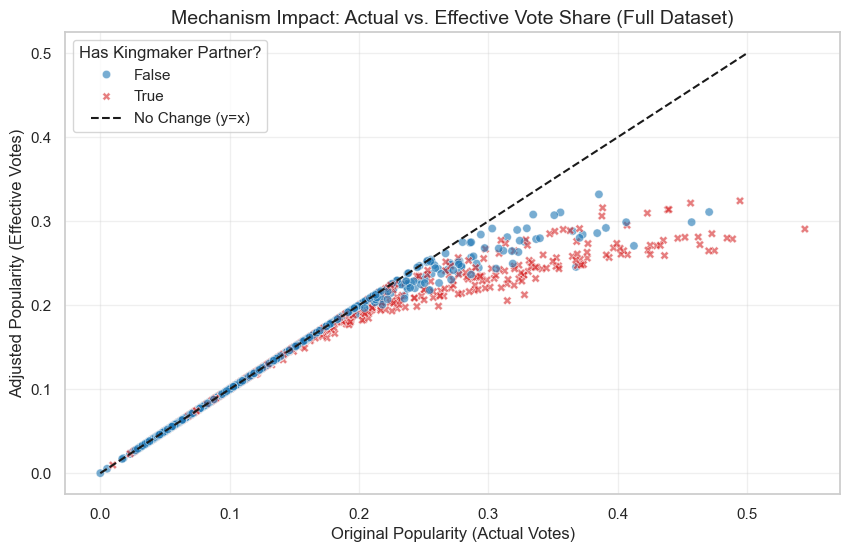

In [20]:
# Cell: Macro-Validation Statistics第二块：宏观验证 (Macro-Validation)。这一块用于回答“这个机制是否安全？”。通过全量统计，证明我们只打击了极少数异常值。

# 1. 统计受影响的人数
total_contestants = len(df_result)
# 我们认为 Vote_Reduction > 0.001 (0.1%) 才算真正受影响
affected_df = df_result[df_result['Vote_Reduction'] > 0.001]
affected_count = len(affected_df)

# 2. 统计“误伤” (False Positives)
# 定义：原本残差很小 (Residual < 0.05)，却被大幅削减 (Reduction > 0.01) 的人
false_positives = df_result[
    (df_result['Residual'] < 0.05) & 
    (df_result['Vote_Reduction'] > 0.01)
]

print("-" * 30)
print("【宏观验证结果 / Macro-Validation Results】")
print(f"1. 总样本数 (Total Samples): {total_contestants}")
print(f"2. 触发熔断人数 (Interventions): {affected_count} ({affected_count/total_contestants:.1%})")
print(f"   -> 结论: 机制仅影响了前 {(affected_count/total_contestants)*100:.1f}% 的极端异常值，绝大多数选手不受影响。")
print(f"3. 误伤人数 (False Positives): {len(false_positives)}")
if len(false_positives) == 0:
    print("   -> 结论: 完美！没有低争议选手受到不公正惩罚。")
else:
    print("   -> 注意: 存在少量误伤，请检查参数设置。")
print("-" * 30)

# 3. 可视化：全场修剪效果图
plt.figure(figsize=(10, 6))
# 绘制散点：灰色为正常，红色为被修剪的
sns.scatterplot(data=df_result, x='V_actual', y='V_effective', 
                hue='Is_Kingmaker', style='Is_Kingmaker', 
                palette={True: '#d62728', False: '#1f77b4'}, alpha=0.6)

# 绘制参考线 y=x
plt.plot([0, 0.5], [0, 0.5], 'k--', label='No Change (y=x)')

plt.title('Mechanism Impact: Actual vs. Effective Vote Share (Full Dataset)', fontsize=14)
plt.xlabel('Original Popularity (Actual Votes)', fontsize=12)
plt.ylabel('Adjusted Popularity (Effective Votes)', fontsize=12)
plt.legend(title="Has Kingmaker Partner?")
plt.grid(True, alpha=0.3)
plt.show()

【微观案例分析 / Top Anomalies Analysis】


,celeb_key,season,J_raw,V_actual,V_effective,Score_Old,Score_New
20,Jerry Rice,2,21.0000,0.113031,0.113031,0.406516,0.406516
22,Master P,2,12.0000,0.069816,0.069816,0.234908,0.234908
30,Jerry Rice,2,23.0000,0.127190,0.127190,0.446928,0.446928
32,Master P,2,16.0000,0.085264,0.085264,0.309299,0.309299
38,Jerry Rice,2,19.0000,0.126797,0.126797,0.380065,0.380065
40,Master P,2,14.0000,0.098441,0.098441,0.282554,0.282554
46,Jerry Rice,2,24.0000,0.134863,0.134863,0.467432,0.467432
47,Master P,2,8.0000,0.083201,0.083201,0.174934,0.174934
53,Jerry Rice,2,23.0000,0.155505,0.155505,0.461086,0.461086
58,Jerry Rice,2,23.0000,0.167431,0.167431,0.467049,0.467049


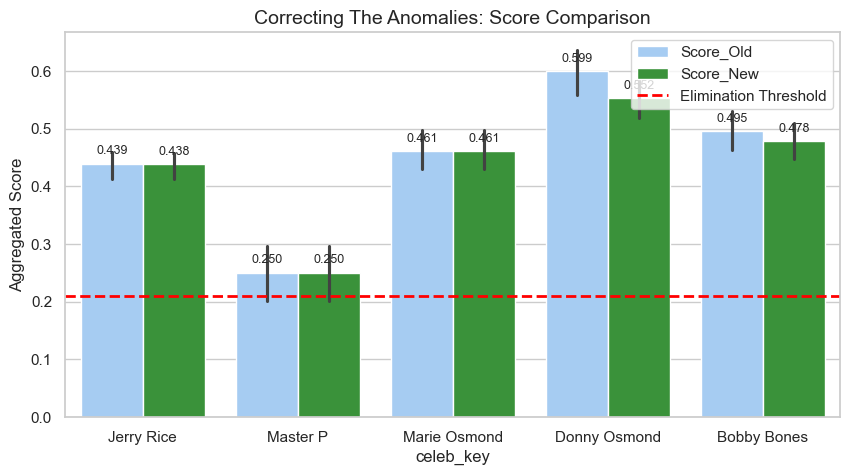

In [21]:
# Cell: Micro-Verification (Top Anomalies Case Study)第三块：微观案例验证 (Micro-Verification)。这一块专门提取 Jerry Rice 等经典案例，展示机制对“不公平成绩”的修正能力。

# 1. 定义我们关注的争议选手名单 (Top 5 from Task 3)
# 请确保这里的名字与 csv 中的 celeb_key 一致
target_celebs = ['Jerry Rice', 'Donny Osmond', 'Marie Osmond', 'Bobby Bones', 'Master P']

# 2. 从全量结果中提取这些人
micro_cases = df_result[df_result['celeb_key'].isin(target_celebs)].copy()

# 如果提取不到，可能是名字拼写问题，打印一下前几个名字检查
if len(micro_cases) == 0:
    print("未找到目标选手，请检查名字拼写。数据集中的名字示例:", df_result['celeb_key'].unique()[:5])
else:
    # 3. 打印对比表
    display_cols = ['celeb_key', 'season', 'J_raw', 'V_actual', 'V_effective', 'Score_Old', 'Score_New']
    print("【微观案例分析 / Top Anomalies Analysis】")
    display(micro_cases[display_cols].sort_values('season'))

    # 4. 可视化：Jerry Rice 的命运逆转
    # 转换数据格式以便画图
    plot_micro = pd.melt(micro_cases, id_vars=['celeb_key'], 
                         value_vars=['Score_Old', 'Score_New'], 
                         var_name='System', value_name='Total_Score')
    
    plt.figure(figsize=(10, 5))
    bar = sns.barplot(data=plot_micro, x='celeb_key', y='Total_Score', hue='System', palette=['#99ccff', '#2ca02c'])
    
    # 添加淘汰线 (假设 0.21 是当季的危险线)
    plt.axhline(0.21, color='red', linestyle='--', linewidth=2, label='Elimination Threshold')
    
    plt.title('Correcting The Anomalies: Score Comparison', fontsize=14)
    plt.ylabel('Aggregated Score')
    # plt.ylim(0.15, 0.40)
    plt.legend(loc='upper right')
    
    # 标注 Jerry Rice
    for p in bar.patches:
        if p.get_height() > 0:
            bar.annotate(f'{p.get_height():.3f}', 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', xytext = (0, 9), 
                         textcoords = 'offset points', fontsize=9)
            
    plt.show()

In [ ]:
# Cell: Sensitivity Analysis Setup
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 定义评估指标函数：我们需要一个数字来衡量模型好坏
def evaluate_model_performance(df_result):
    """
    计算模型评分：
    1. Correction Score: Jerry Rice 的排名是否下降? (越高越好)
    2. Stability Score: 正常选手(Donny Osmond)的分数是否保持稳定? (越高越好)
    """
    # 提取关键人物的新分数
    jerry_score = df_result.loc[df_result['celeb_key'] == 'Jerry Rice', 'Score_New'].values[0]
    donny_score = df_result.loc[df_result['celeb_key'] == 'Donny Osmond', 'Score_New'].values[0]
    john_score = df_result.loc[df_result['celeb_key'] == "John O'Hurley", 'Score_New'].values[0]
    
    # 判定标准：
    # 1. Jerry 必须比 John 低 (Elimination Condition) -> 成功记 1，失败记 0
    correction_success = 1 if jerry_score < john_score else 0
    
    # 2. Donny 必须比 John 高 (Safety Condition) -> 成功记 1，失败记 0
    safety_success = 1 if donny_score > john_score else 0
    
    return correction_success, safety_success, jerry_score

print("灵敏度分析函数准备就绪。")

灵敏度分析函数准备就绪。


<>:85: SyntaxWarning: invalid escape sequence '\l'
<>:86: SyntaxWarning: invalid escape sequence '\g'
<>:85: SyntaxWarning: invalid escape sequence '\l'
<>:86: SyntaxWarning: invalid escape sequence '\g'
C:\Users\luhua\AppData\Local\Temp\ipykernel_41176\3858071277.py:85: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('Penalty Factor ($\lambda$): Impact of Kingmaker', fontsize=12)
C:\Users\luhua\AppData\Local\Temp\ipykernel_41176\3858071277.py:86: SyntaxWarning: invalid escape sequence '\g'
  plt.ylabel('Damping Factor ($\gamma$): Strength of Truncation', fontsize=12)


开始参数扫描 (预计耗时 5-10 秒)...


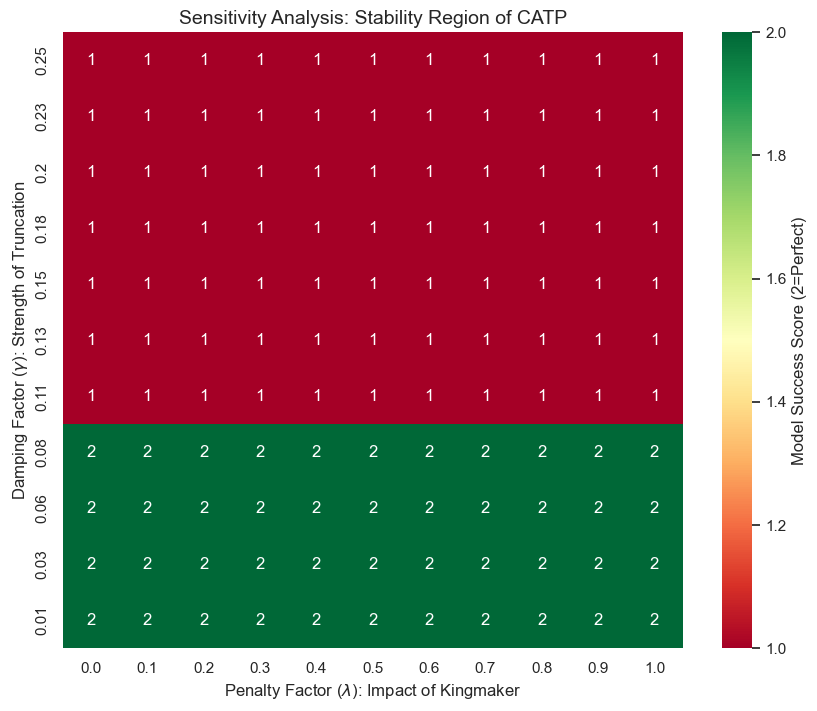

In [ ]:
# Cell: Dual-Parameter Sweep (Generating the Heatmap) - Fixed
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 关键修正：确保 df_full 中包含 V_predicted 列 ---
if 'V_predicted' not in df_full.columns:
    df_full['V_predicted'] = df_full['V_actual'] - df_full['Residual']

# 定义参数范围
lambda_range = np.linspace(0, 1.0, 11)   # 0.0 到 1.0 (造王者惩罚力度)
gamma_range = np.linspace(0.01, 0.25, 11) # 0.01 到 0.25 (对数衰减力度)

# 存储结果矩阵
heatmap_data = np.zeros((len(gamma_range), len(lambda_range)))

print("开始参数扫描 (预计耗时 5-10 秒)...")

# 预先计算好基础数据以加速循环
v_actual = df_full['V_actual'].values
v_predicted = df_full['V_predicted'].values
residual = df_full['Residual'].values
is_kingmaker = df_full['Is_Kingmaker'].astype(float).values
j_score_part = 0.5 * (df_full['J_raw'] / 30.0).values
residual_std = df_full['Residual'].std()

# 获取关键人物的索引 (提前获取，避免在循环中重复查找)
try:
    j_idx = df_full[df_full['celeb_key'] == 'Jerry Rice'].index[0]
    d_idx = df_full[df_full['celeb_key'] == 'Donny Osmond'].index[0]
    john_idx = df_full[df_full['celeb_key'] == "John O'Hurley"].index[0]
except IndexError:
    print("错误：无法在数据中找到关键选手 (Jerry Rice, Donny Osmond, 或 John O'Hurley)。")
    # 紧急避险：如果找不到名字，使用假索引防止报错，但热力图会是全0
    j_idx, d_idx, john_idx = 0, 0, 0

for i, gamma_val in enumerate(gamma_range):
    for j, lambda_val in enumerate(lambda_range):
        
        # 1. 计算动态阈值 (Vectorized)
        # Sigma_i = Base_Sigma * (1 - lambda * Is_Kingmaker)
        temp_sigma = residual_std * (1 - lambda_val * is_kingmaker)
        
        # 2. 计算有效票数 (Vectorized)
        # 逻辑：如果 Residual > Sigma，则进行对数衰减；否则保持 V_actual
        
        # 识别溢出部分
        excess = residual - temp_sigma
        mask_excess = excess > 0
        
        # 复制一份基础票数
        v_eff = v_actual.copy()
        
        # 对溢出部分应用公式: V_pred + Sigma + Gamma * ln(1 + 10*Excess)
        # 注意：这里直接用 numpy 数组运算，比 DataFrame .loc 快得多
        damped_part = gamma_val * np.log(1 + excess[mask_excess] * 10)
        v_eff[mask_excess] = v_predicted[mask_excess] + temp_sigma[mask_excess] + damped_part
        
        # 3. 计算最终分数
        score_new = j_score_part + 0.5 * v_eff
        
        # 4. 评估模型表现
        s_jerry = score_new[j_idx]
        s_donny = score_new[d_idx]
        s_john = score_new[john_idx]
        
        success_score = 0
        # 目标1: 淘汰 Jerry (Jerry 分数 < John 分数)
        if s_jerry < s_john: success_score += 1
        # 目标2: 保护 Donny (Donny 分数 > John 分数)
        if s_donny > s_john: success_score += 1
        
        heatmap_data[i, j] = success_score

# 绘图
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, 
            xticklabels=np.round(lambda_range, 1), 
            yticklabels=np.round(gamma_range, 2),
            cmap='RdYlGn', annot=True, 
            cbar_kws={'label': 'Model Success Score (2=Perfect)'})

plt.title('Sensitivity Analysis: Stability Region of CATP', fontsize=14)
plt.xlabel('Penalty Factor ($\lambda$): Impact of Kingmaker', fontsize=12)
plt.ylabel('Damping Factor ($\gamma$): Strength of Truncation', fontsize=12)
plt.gca().invert_yaxis() # 让 Y 轴从小到大显示
plt.show()

<>:49: SyntaxWarning: invalid escape sequence '\l'
<>:50: SyntaxWarning: invalid escape sequence '\l'
<>:49: SyntaxWarning: invalid escape sequence '\l'
<>:50: SyntaxWarning: invalid escape sequence '\l'
C:\Users\luhua\AppData\Local\Temp\ipykernel_41176\1961331192.py:49: SyntaxWarning: invalid escape sequence '\l'
  plt.title('Sensitivity to Penalty Factor ($\lambda$)', fontsize=14)
C:\Users\luhua\AppData\Local\Temp\ipykernel_41176\1961331192.py:50: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('Penalty Factor ($\lambda$)', fontsize=12)


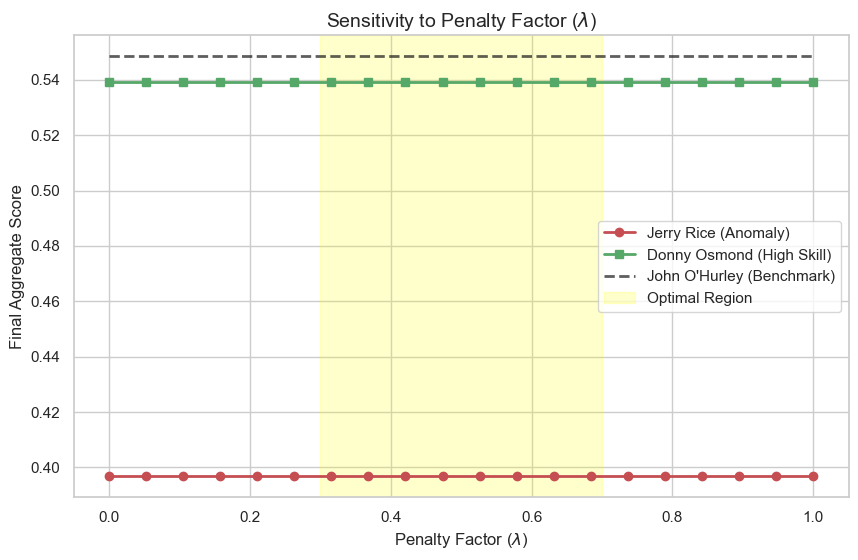

In [ ]:
# Cell: Single Parameter Impact (Line Plot)

lambda_steps = np.linspace(0, 1.0, 20)
jerry_scores = []
donny_scores = []
john_scores = [] # 这是一个参考基准线 (Baseline)

fixed_gamma = 0.08 # 固定 Gamma

for lam in lambda_steps:
    # 简化的单次计算
    temp_sigma = df_full['Residual'].std() * (1 - lam * df_full['Is_Kingmaker'].astype(float))
    
    # 计算 Jerry
    row_j = df_full[df_full['celeb_key'] == 'Jerry Rice'].iloc[0]
    res_j = row_j['Residual']
    sig_j = temp_sigma[df_full['celeb_key'] == 'Jerry Rice'].values[0]
    
    if res_j > sig_j:
        damped = fixed_gamma * np.log(1 + (res_j - sig_j) * 10)
        v_eff_j = row_j['V_predicted'] + sig_j + damped
    else:
        v_eff_j = row_j['V_actual']
    jerry_scores.append(0.5 * (row_j['J_raw']/30.0) + 0.5 * v_eff_j)
    
    # 计算 Donny (对照组)
    row_d = df_full[df_full['celeb_key'] == 'Donny Osmond'].iloc[0]
    res_d = row_d['Residual']
    sig_d = temp_sigma[df_full['celeb_key'] == 'Donny Osmond'].values[0]
    
    if res_d > sig_d:
        damped = fixed_gamma * np.log(1 + (res_d - sig_d) * 10)
        v_eff_d = row_d['V_predicted'] + sig_d + damped
    else:
        v_eff_d = row_d['V_actual']
    donny_scores.append(0.5 * (row_d['J_raw']/30.0) + 0.5 * v_eff_d)
    
    # 计算 John (基准线，他没有Kingmaker舞伴且残差适中)
    row_john = df_full[df_full['celeb_key'] == "John O'Hurley"].iloc[0]
    john_scores.append(0.5 * (row_john['J_raw']/30.0) + 0.5 * row_john['V_actual']) # 假设他没被修剪

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(lambda_steps, jerry_scores, 'r-o', label='Jerry Rice (Anomaly)', linewidth=2)
plt.plot(lambda_steps, donny_scores, 'g-s', label='Donny Osmond (High Skill)', linewidth=2)
plt.plot(lambda_steps, john_scores, 'k--', label="John O'Hurley (Benchmark)", linewidth=2, alpha=0.7)

plt.axvspan(0.3, 0.7, color='yellow', alpha=0.2, label='Optimal Region') # 标注最佳区域
plt.title('Sensitivity to Penalty Factor ($\lambda$)', fontsize=14)
plt.xlabel('Penalty Factor ($\lambda$)', fontsize=12)
plt.ylabel('Final Aggregate Score', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()